In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import os
import random
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
Dpath = "/content/gdrive/My Drive/wdbc.data"
Dheader = ["id", "diagnosis", "mean_radius", "mean_texture", "mean_perimeter", "mean_area", "mean_smoothness", "mean_compactness", "mean_concavity", "mean_conPoints", "mean_symmetry" ,"mean_fracDim", "SE_radius", "SE_texture", "SE_perimeter", "SE_area", "SE_smoothness", "SE_compactness", "SE_concavity", "SE_conPoints", "SE_symmetry" ,"SE_fracDim", "worst_radius", "worst_texture", "worst_perimeter", "worst_area", "worst_smoothness", "worst_compactness", "worst_concavity", "worst_conPoints", "worst_symmetry" ,"worst_fracDim"]
DSE = ["SE_radius", "SE_texture", "SE_perimeter", "SE_area", "SE_smoothness", "SE_compactness", "SE_concavity", "SE_conPoints", "SE_symmetry" ,"SE_fracDim"]
D = pd.read_csv(Dpath, sep=',', header=None)
D.columns=Dheader
diag = [0 if s == 'B' else 1 for s in D[Dheader[1]]]
D[Dheader[1]] = diag
D=D.drop(columns=(['id']))

In [0]:
# disease
print("%d malign samples of %d total samples, which are %.2f %%."%(D['diagnosis'].sum(),len(D['diagnosis']),D['diagnosis'].sum()/ len(D['diagnosis'])))

212 malign samples of 569 total samples, which are 0.37 %.


In [0]:
Dfeat=list(set(Dheader).difference(set(DSE)))
Dfeat.remove('id')

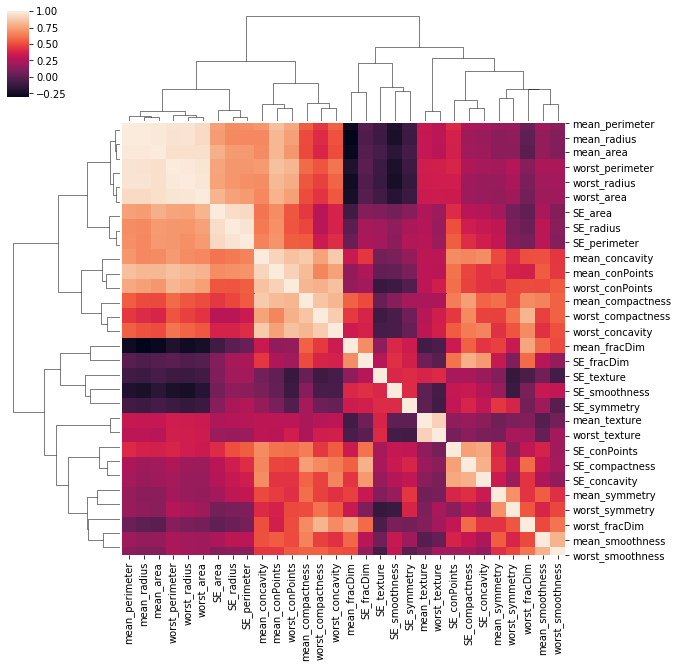

In [0]:
sns.clustermap(D[Dheader[2:]].corr(),method='complete')

In [0]:
# D is whole frame, features is list of features (including diagnosis) k-fold testing
def SVM_test(D,features,k=10):
  C = D[features]
  # create k chunk-pairs for k-fold training and testing
  k = 10
  indices = list(range(len(C.index)))
  random.shuffle(indices)
  n=math.ceil(len(indices)/k)
  chunksTest = [indices[i:i+n] for i in range(0,len(C.index),n)]
  chunksTrain= [list(set(indices).difference(set(chunk))) for chunk in chunksTest]

  ACCU,TP,TN,FP,FN = 0,0,0,0,0
  svclassifier = SVC(kernel='linear')
  for i in range(k):
    svclassifier.fit(C.iloc[chunksTrain[i],1:], C.iloc[chunksTrain[i],0])
    prediction = svclassifier.predict(C.iloc[chunksTest[i],1:])
    TP   += sum( prediction   &  C.iloc[chunksTest[i],0])  /k
    TN   += sum(~prediction+2 & ~C.iloc[chunksTest[i],0]+2)/k
    FP   += sum( prediction   & ~C.iloc[chunksTest[i],0]+2)/k
    FN   += sum(~prediction+2 &  C.iloc[chunksTest[i],0])  /k
  ACC = (TP+TN)/(TP+TN+FP+FN)
  return(ACC,TP,TN,FP,FN)

In [0]:
# features = list of feature names, k in k-testing
def SVM_best_feature_selection(D,features,delta = 0.005,k=10):
  current_features = ['diagnosis']
  scores = [0.0]

  for i in range(1,len(features)):
    max_feat  = ''
    max_score = 0.0

    for e in set(features).difference(set(current_features)):
      score = SVM_test(D,current_features+[e])[0]
      
      if score > max_score:
        max_score = score
        max_feat = e

    current_features.append(max_feat)
    scores.append(max_score)
    
    if (abs(scores[i] - scores[i-1]) <= delta) or (scores[i] <= scores[i-1]):
      return(current_features,scores)
  
  return(current_features,scores)


In [0]:
all_features=list(D.corr()['diagnosis'].sort_values(ascending=False).index)
selected_features,feature_scores = SVM_best_feature_selection(D,all_features[:],delta = 0.001,k=10)

(0.9064850615114236, 1.0)

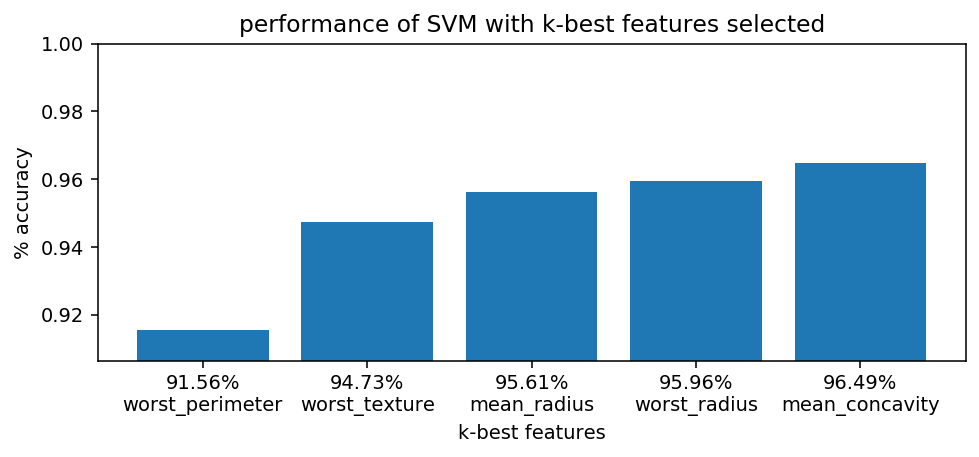

In [44]:
#selected_features = selected_features[:-1]
#feature_scores = feature_scores[:-1]
plt.figure(figsize=((8,3)), dpi=140)
plt.bar(range(len(feature_scores))[1:],feature_scores[1:],tick_label=["%.2f%%\n%s"%(100.0*feature_scores[i],selected_features[i]) for i in range(1,len(selected_features))])
plt.title("performance of SVM with k-best features selected")
plt.ylabel("% accuracy")
plt.xlabel("k-best features")
plt.xticks(rotation=0)
plt.ylim(min(feature_scores[1:])*0.99,1.0)